In [24]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.io as pio

pio.renderers.default = "vscode"

In [25]:
def get_capacity_utilization(dir: str) -> pd.DataFrame:
    nc = pd.read_csv(dir + "/nc_shipped.csv")
    cisf = pd.read_csv(dir + "/cisf_build.csv")

    cisf_stock = nc.query("NC>0").groupby(by="to", as_index=False).agg(amount = ("NC", "sum"))

    built = cisf[cisf["build"] != 0]
    capacities = pd.DataFrame(np.array([["small", 150], ["medium", 375], ["large", 500], ["xlarge", 750], ["complete", 1075]]), columns=["version", "capacity"]).astype({"capacity": "int32"})

    cisf_utilization = pd.merge(left=built, left_on="size", right=capacities, right_on="version").drop(columns="version")
    cisf_utilization = pd.merge(left=cisf_utilization, left_on="cisf", right=cisf_stock, right_on="to").drop(columns="to")

    cisf_utilization["cap_util"] = np.round(cisf_utilization["amount"] / cisf_utilization["capacity"], 2)

    return cisf_utilization

#### Single scenario

In [26]:
n_cisf = 3
n_hc = 3

nc = pd.read_csv("C:/Users/ACER/Desktop/Uni/9_WiSe_23_24/OR-INF/operations_oppenheimer/operations_oppenheimer/storage/n_hc_" + str(n_hc) + "/n_cisf_" + str(n_cisf) + "/nc_shipped.csv")
cisf = pd.read_csv("C:/Users/ACER/Desktop/Uni/9_WiSe_23_24/OR-INF/operations_oppenheimer/operations_oppenheimer/storage/n_hc_" + str(n_hc) + "/n_cisf_" + str(n_cisf) + "/cisf_build.csv")

In [27]:
cisf_stock = nc.query("NC>0").groupby(by="to", as_index=False).agg(amount = ("NC", "sum"))

In [28]:
built = cisf[cisf["build"] != 0]
capacities = pd.DataFrame(np.array([["small", 150], ["medium", 375], ["large", 500], ["xlarge", 750], ["complete", 1075]]), columns=["version", "capacity"]).astype({"capacity": "int32"})

cisf_utilization = pd.merge(left=built, left_on="size", right=capacities, right_on="version").drop(columns="version")
cisf_utilization = pd.merge(left=cisf_utilization, left_on="cisf", right=cisf_stock, right_on="to").drop(columns="to")

cisf_utilization["cap_util"] = np.round(cisf_utilization["amount"] / cisf_utilization["capacity"], 2)

In [29]:
fig = px.bar(data_frame=cisf_utilization,
             x="cisf",
             y="cap_util",
             color="size",
             labels={"node": "", "cap_util": "Capacity utilization", "size": "CISF version"},
             title="Capacity utilization of constructed CISF",
             template = "seaborn")

fig.show()

#### Cross-scenario analysis

In [30]:
import yaml

In [32]:
n_cisf_max = 7
n_hc_max = 4

In [33]:
rows = []

for hc in range(1, n_hc_max):
    for c in range(1, n_cisf_max):
        cisf_utilization = get_capacity_utilization(dir="C:/Users/ACER/Desktop/Uni/9_WiSe_23_24/OR-INF/operations_oppenheimer/operations_oppenheimer/storage/n_hc_" + str(hc) + "/n_cisf_" + str(c))
        avg_util = np.mean(cisf_utilization["cap_util"])
        rows.append({
            "n_hc": hc,
            "n_cisf": c,
            "avg_cisf_utilization": avg_util
        })

scenarios = pd.DataFrame(rows)        

In [34]:
px.density_heatmap(scenarios,
          x="n_cisf",
          y="n_hc",
          z="avg_cisf_utilization",
          color_continuous_scale="Hot")

#### Old content 

In [2]:
reactors = pd.read_csv("../../data/output_data/reactor_operating.csv")
snf_s = pd.read_csv("../../data/output_data/snf_stored.csv")
nc_s = pd.read_csv("../../data/output_data/nc_stored.csv")

reactor_details = pd.read_excel("../../data/ExtendedNuclearData.xlsx", sheet_name="Reactors")

In [3]:
reactors_active = reactors[reactors["build"] != 0]
active_per_year = reactors_active.groupby(by="year", as_index=False).agg(n_active = ("build", "sum"))

<Axes: xlabel='year', ylabel='n_active'>

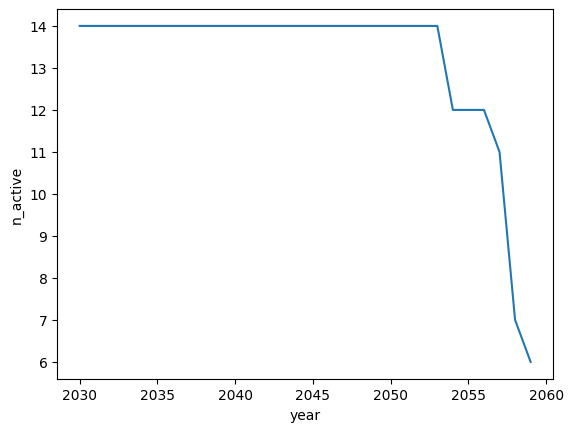

In [4]:
sns.lineplot(data=active_per_year,
             x="year",
             y="n_active")

In [5]:
reactors_unique = reactors_active["reactor"].unique()

In [6]:
storage = (pd.merge(left=snf_s.astype({"year": "str"}).assign(key = lambda d: d.node + d.year), left_on="key",
         right=nc_s.astype({"year": "str"}).assign(key = lambda d: d.node + d.year), right_on="key")
         .drop(columns=["node_y", "year_y", "key"])
         .rename(columns ={"node_x": "node",
                 "year_x": "year"}))

storage["type"] = np.where(storage["node"].isin(reactors_unique), "Reactor", "CISF")

In [7]:
storage_long = pd.melt(frame=storage, id_vars=["node", "year", "type"], value_name="amount", var_name="waste_type")

In [36]:
utilization = storage_long.groupby(by=["year", "node"], as_index=False).agg(amount = ("amount", "sum"), type = ("type", "first"))

cisf_utilization = utilization[(utilization["year"] == np.max(utilization["year"])) & (utilization["amount"] != 0)]
cisf_utilization = pd.merge(left=cisf_utilization, left_on="node", right=built.drop(columns=["year", "build"]), right_on="cisf")
cisf_utilization = pd.merge(left=cisf_utilization, left_on="size", right=capacities, right_on="size")
cisf_utilization["cap_util"] = np.round(cisf_utilization["amount"] / cisf_utilization["capacity"], 2)

In [45]:
fig = px.bar(data_frame=cisf_utilization,
             x="node",
             y="cap_util",
             color="size",
             labels={"node": "", "cap_util": "Capacity utilization", "size": "CISF version"},
             title="Capacity utilization of constructed CISF",
             template = "seaborn")

fig.show()

In [8]:
storage_distribution = storage_long.groupby(by=["year", "type", "waste_type"], as_index=False).agg(amount = ("amount", "sum"))

In [ ]:
g = sns.FacetGrid(storage_distribution, col="type", hue="waste_type", height=5)
g.map(sns.barplot, "year", "amount", ci=None)

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

In [9]:
reactor_storage = pd.merge(left=storage, left_on="node", right=reactor_details, right_on="name", how="left")

reactor_storage = reactor_storage.dropna().drop(columns=["name", "type", "costs", "snf"]).assign(total_stock= lambda d: d.SNF + d.NC)

reactor_storage["utilization"] = np.round(reactor_storage["total_stock"] / reactor_storage["capacity"], 3)

In [ ]:
plot = sns.lineplot(data=reactor_storage,
             x="year",
             y="utilization",
             hue="node")

plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

In [18]:
px.line(data_frame=reactor_storage,
             x="year",
             y="utilization",
             color="node",
             title = "Capacity utilization at reactor storage sites",
             template = "seaborn",
             labels = {"node": "Reactor"})